Use `hyperopt` to get optimal parameters for optical flow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import sys
BASE_PATH = pathlib.Path('..')
sys.path.append(BASE_PATH.name)

import common.loss_utils as loss_utils
import common.utils as utils


/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
p = BASE_PATH / 'data/train.npz'
f = np.load(p)
times = f['times']
data = f['data']

In [4]:
times.shape, data.shape

((41896,), (41896, 325, 400))

In [8]:
class DataFetcher:
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[:, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not utils.check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data)

In [9]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [10]:
x, y = ds[0]

In [11]:
x.shape, y.shape

((12, 128, 128), (24, 64, 64))

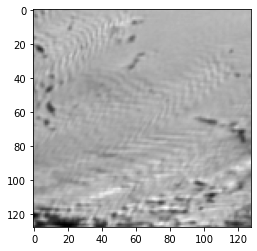

In [12]:
plt.imshow(x[0], cmap='gray')

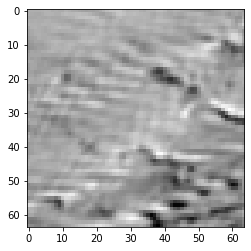

In [13]:
plt.imshow(y[0], cmap='gray')

In [14]:
LOOKS = 500


In [15]:
pers_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = x[-1:,32:96,32:96]
    preds = np.tile(preds, (y.shape[0], 1, 1))
    score = utils.get_msssim(preds, y, inner_64=False)
    pers_scores.append(score)


100%|██████████| 500/500 [00:03<00:00, 159.46it/s]


In [16]:
np.mean(pers_scores)

0.6367134

In [25]:
optical_flow_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    # rando parameters
    flow = cv2.calcOpticalFlowFarneback(
        prev=x[-1],
        next=x[-2],
        flow=None,
        pyr_scale=0.5, levels=3, winsize=15, 
        iterations=10, poly_n=5, poly_sigma=1.2, 
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    )
    flow = -flow
    start = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(24):
        # there are many ways we could do this... we tried just vanilla multiplying the flow
        # and also fixing the flow field and having pixels flow "through" it. the interpretation
        # here would be that winds are constant and clouds flow through them
        # experimentation revealed the latter did slightly bettter, but the current implementation
        # is simpler.
        cur = utils.warp_flow(start, flow*(j+1))
        preds[j] = cur[32:96,32:96]
    
    score = utils.get_msssim(preds, y, inner_64=False)
    optical_flow_scores.append(score)


100%|██████████| 500/500 [00:08<00:00, 58.81it/s]


In [26]:
np.mean(optical_flow_scores)

0.6507268

In [56]:
def score_optical_flow_params(forecast=1, verbose=False, **params):
    running_total = 0
    iterable = tqdm.tqdm(range(LOOKS)) if verbose else range(LOOKS)
    for i in iterable:
        x, y = ds[indices[i]]
        y = y[:forecast]
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[-1],
            next=x[-2],
            flow=None,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
            **params,
        )
        flow = -flow
        start = x[-1].astype(np.float32)
        preds = np.zeros(y.shape, dtype=np.float32)
        for j in range(forecast):
            cur = utils.warp_flow(start, flow*(j+1))
            preds[j,:,:] = cur[32:96,32:96]
        running_total += utils.get_msssim(preds, y, inner_64=False)
    return running_total / LOOKS

In [57]:
# just see which params give the best prediction for the next timestep
# we can test propogation by increasing forecast
def objective(params):
    # negative cause minimize
    return -score_optical_flow_params(forecast=1, **params)

In [58]:
space = dict(
    pyr_scale=hp.uniform('pyr_scale', 0.0, 1.0), 
    levels=hp.uniformint('levels', 1, 10),
    winsize=hp.uniformint('winsize', 1, 20),
    iterations=hp.uniformint('iterations', 1, 20),
    poly_n=hp.uniformint('poly_n', 1, 10),
    poly_sigma=hp.uniform('poly_sigma', 0.0, 1.5)
)

In [59]:
trials = Trials()

In [ ]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

 44%|████▍     | 44/100 [04:47<07:51,  8.42s/trial, best loss: -0.9553442507982254]

In [407]:
trials.best_trial['misc']['vals']

{'iterations': [1.0],
 'levels': [7.0],
 'poly_n': [1.0],
 'poly_sigma': [1.4693672666935025],
 'pyr_scale': [0.11929344253533095],
 'winsize': [14.0]}

In [408]:
not_int = ['pyr_scale', 'poly_sigma']

d = dict()
for k, v in trials.best_trial['misc']['vals'].items():
    if k in not_int:
        d[k] = v[0]
    else:
        d[k] = int(v[0])
    

In [409]:
d

{'iterations': 1,
 'levels': 7,
 'poly_n': 1,
 'poly_sigma': 1.4693672666935025,
 'pyr_scale': 0.11929344253533095,
 'winsize': 14}